In [1]:
import pandas as pd
import numpy as np
from pyjet import cluster,DTYPE_PTEPM
from sklearn import preprocessing

# Pre processing

In [2]:
path = path = '/anomalyvol/data/events_LHCO2020_backgroundMC_Pythia.h5'

In [3]:
df = pd.read_hdf(path,stop=50000) # just read first 50000 events

In [4]:
all_events = df.values

In [5]:
rows = all_events.shape[0]
cols = all_events.shape[1]
data = []

In [6]:
for i in range(rows):
    pseudojets_input = np.zeros(len([x for x in all_events[i][::3] if x > 0]), dtype=DTYPE_PTEPM)
    for j in range(cols // 3):
        if (all_events[i][j*3]>0):
            pseudojets_input[j]['pT'] = all_events[i][j*3]
            pseudojets_input[j]['eta'] = all_events[i][j*3+1]
            pseudojets_input[j]['phi'] = all_events[i][j*3+2]
        pass
    sequence = cluster(pseudojets_input, R=1.0, p=-1)
    jets = sequence.inclusive_jets()
    for k in range(len(jets)):
        jet = []
        jet.append(jets[k].pt)
        jet.append(jets[k].eta)
        jet.append(jets[k].phi)
        jet.append(jets[k].mass)
        data.append(jet)

In [7]:
data = np.array(data)
data.shape

(738745, 4)

In [8]:
# splitting data
x_train = data[0:int(len(data) * 0.8)]
x_val = data[int(len(data) * 0.8):int(len(data) * 0.9)]
x_test = data[int(len(data) * 0.9):]

In [9]:
# regularize
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# VAE Model

In [10]:
import keras
from keras.layers import Lambda, Input, Dense, Flatten, Reshape
from keras.models import Model, Sequential
from keras import metrics, losses
from keras import backend as K

Using TensorFlow backend.


In [11]:
def sampling(args):
    """
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [12]:
inter_dim_1 = 32
inter_dim_2 = 16
final_dim = 8
latent_dim = 4
input_dim = 4

In [13]:
# encoder
x = Input(shape=(input_dim,))
#x_flat = Flatten()(x)
h1 = Dense(inter_dim_1, activation='relu')(x)
h2 = Dense(inter_dim_2, activation='relu')(h1)
h3 = Dense(final_dim, activation='relu')(h2)
z_mean = Dense(latent_dim)(h3)
z_log_sigma = Dense(latent_dim)(h2)

In [14]:
# random sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

encoder = Model(inputs = x, outputs = z)

In [15]:
# decoder
decoder_h3 = Dense(final_dim, activation='relu')
decoder_h2 = Dense(inter_dim_2, activation='relu')
decoder_h1 = Dense(inter_dim_1, activation='relu')
decoder_mean = Dense(input_dim, activation='linear')

h3_decoded = decoder_h3(z)
h2_decoded = decoder_h2(h3_decoded)
h1_decoded = decoder_h1(h2_decoded)
x_decoded_mean = decoder_mean(h1_decoded)
# x_decoded = Reshape(input_shape)(x_decoded_mean)

In [16]:
vae = Model(inputs = x, outputs = x_decoded_mean, name = 'vae')

In [17]:
mse = keras.losses.MeanSquaredError()
def vae_loss(x, y):
    mse_loss = mse(x, y)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return mse_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)

In [18]:
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1280        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           8256        dense_2[0][0]                    
________________________________________________________________________________________________

# Train

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
batch_size = 500
epochs = 100

In [21]:
x_train.shape

(590996, 4)

In [22]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10)
]

In [23]:
hist = vae.fit(x_train, x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_val, x_val),
               callbacks=my_callbacks)

Train on 590996 samples, validate on 73874 samples
Epoch 1/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6280 - val_loss: 0.6088
Epoch 2/100
590996/590996 [==============================] - 8s 13us/step - loss: 0.6074 - val_loss: 0.6031
Epoch 3/100
590996/590996 [==============================] - 8s 14us/step - loss: 0.6058 - val_loss: 0.6053
Epoch 4/100
590996/590996 [==============================] - 8s 14us/step - loss: 0.6060 - val_loss: 0.6064
Epoch 5/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6055 - val_loss: 0.6058
Epoch 6/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6045 - val_loss: 0.6059
Epoch 7/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6056 - val_loss: 0.6033
Epoch 8/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6042 - val_loss: 0.6067
Epoch 9/100
590996/590996 [==============================] - 9s 15us/step - loss: 0.6

# Visualization

In [24]:
import matplotlib.pyplot as plt

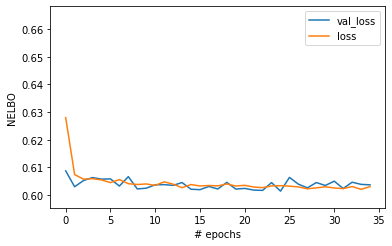

In [40]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())
plt.show()

In [56]:
predictions = vae.predict(x_test)

In [57]:
predictions

array([[-0.42531464,  1.2027376 ,  0.44998312, -0.3291189 ],
       [-0.39020225, -0.7126987 ,  0.57134986, -0.30732858],
       [ 2.1891022 , -0.02447707,  0.5832078 ,  0.7632716 ],
       ...,
       [-0.41169366, -1.2293227 ,  1.0225103 , -0.3247236 ],
       [-0.41287628,  1.1133944 , -0.74467665, -0.31705886],
       [-0.42888555,  1.2784923 ,  0.37913418, -0.33292723]],
      dtype=float32)

In [58]:
distr = (x_test - predictions) / x_test

In [59]:
pT_pred = [row[0] for row in predictions]
eta_pred = [row[1] for row in predictions]
phi_pred = [row[2] for row in predictions]
mass_pred = [row[3] for row in predictions]

In [60]:
pT = [row[0] for row in x_test]
eta = [row[1] for row in x_test]
phi = [row[2] for row in x_test]
mass = [row[3] for row in x_test]

## Stacking output (orange) over input (blue) for pT, eta, phi, m

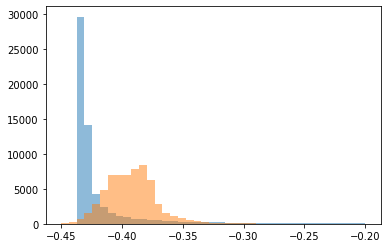

In [61]:
bins = np.linspace(-0.45, -0.2, 40)
plt.hist(pT, bins=bins,alpha=0.5)
plt.hist(pT_pred, bins=bins,alpha=0.5)
bins = np.linspace(-0.45, -0.2, 40)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 9.000e+00, 5.000e+01,
        2.520e+02, 6.410e+02, 1.142e+03, 1.346e+03, 1.516e+03, 1.640e+03,
        1.646e+03, 1.643e+03, 1.724e+03, 1.721e+03, 1.568e+03, 1.416e+03,
        1.234e+03, 1.278e+03, 1.219e+03, 1.233e+03, 1.206e+03, 1.091e+03,
        1.080e+03, 9.920e+02, 9.630e+02, 9.790e+02, 1.039e+03, 1.026e+03,
        1.041e+03, 1.411e+03, 3.419e+03, 6.521e+03, 1.959e+03, 1.191e+03,
        9.410e+02, 9.580e+02, 9.710e+02, 1.026e+03, 1.004e+03, 9.970e+02,
        1.016e+03, 9.760e+02, 9.900e+02, 1.063e+03, 1.232e+03, 1.217e+03,
        1.312e+03, 1.382e+03, 1.509e+03, 1.644e+03, 1.605e+03, 1.654e+03,
        1.674e+03, 1.524e+03, 1.257e+03, 1.154e+03, 8.390e+02, 4.730e+02,
        2.170e+02, 4.000e+01, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-2.      

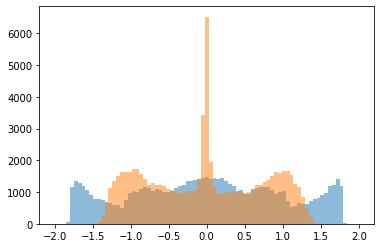

In [62]:
bins = np.linspace(-2, 2, 80)
plt.hist(eta, bins=bins,alpha=0.5)
plt.hist(eta_pred, bins=bins,alpha=0.5)

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 9.000e+00, 1.500e+01, 4.000e+01,
        8.400e+01, 3.590e+02, 8.560e+02, 1.036e+03, 1.319e+03, 1.461e+03,
        1.740e+03, 1.802e+03, 1.859e+03, 1.652e+03, 1.604e+03, 1.572e+03,
        1.450e+03, 1.395e+03, 1.348e+03, 1.256e+03, 1.285e+03, 1.179e+03,
        1.108e+03, 1.141e+03, 1.152e+03, 1.095e+03, 9.550e+02, 9.530e+02,
        1.017e+03, 9.510e+02, 9.930e+02, 9.490e+02, 1.026e+03, 9.780e+02,
        9.690e+02, 1.020e+03, 9.500e+02, 1.001e+03, 1.052e+03, 9.810e+02,
        9.870e+02, 1.033e+03, 1.027e+03, 9.350e+02, 9.670e+02, 1.086e+03,
        1.186e+03, 1.183e+03, 1.194e+03, 1.201e+03, 1.214e+03, 1.350e+03,
        1.338e+03, 1.477e+03, 1.510e+03, 1.522e+03, 1.477e+03, 1.530e+03,
        1.484e+03, 1.466e+03, 1.719e+03, 1.567e+03, 1.392e+03, 9.730e+02,
        7.320e+02, 4.640e+02, 1.910e+0

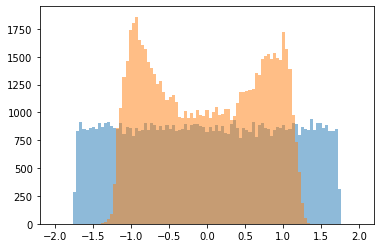

In [63]:
bins = np.linspace(-2,2, 100)
plt.hist(phi, bins=bins,alpha=0.5)
plt.hist(phi_pred, bins=bins,alpha=0.5)

(array([0.0000e+00, 2.0000e+00, 3.6680e+03, 2.7442e+04, 2.6195e+04,
        3.8040e+03, 6.8100e+02, 3.2800e+02, 1.7400e+02, 1.1400e+02,
        7.7000e+01, 6.8000e+01, 4.6000e+01, 4.5000e+01, 3.4000e+01,
        3.1000e+01, 3.7000e+01, 3.0000e+01, 3.8000e+01, 4.0000e+01,
        3.9000e+01, 4.2000e+01, 3.0000e+01, 3.4000e+01, 2.7000e+01,
        4.0000e+01, 3.8000e+01, 3.8000e+01, 5.5000e+01, 4.9000e+01,
        5.2000e+01, 5.4000e+01, 4.9000e+01, 5.8000e+01, 6.8000e+01,
        8.5000e+01, 8.0000e+01, 9.5000e+01, 9.9000e+01, 1.2000e+02,
        1.2800e+02, 1.3400e+02, 1.7200e+02, 1.9000e+02, 1.9200e+02,
        2.0800e+02, 2.2300e+02, 2.2300e+02, 2.1500e+02, 2.1000e+02,
        1.9100e+02, 1.9200e+02, 1.8700e+02, 1.5600e+02, 1.4100e+02,
        1.6600e+02, 1.3700e+02, 1.3100e+02, 1.2300e+02]),
 array([-0.4       , -0.37627119, -0.35254237, -0.32881356, -0.30508475,
        -0.28135593, -0.25762712, -0.23389831, -0.21016949, -0.18644068,
        -0.16271186, -0.13898305, -0.11525424, -

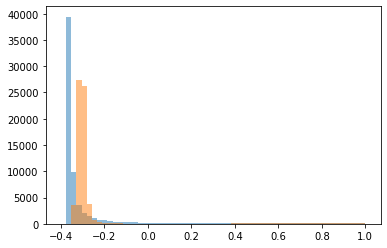

In [64]:
bins = np.linspace(-.4,1, 60)
plt.hist(mass, bins=bins,alpha=0.5)
plt.hist(mass_pred, bins=bins,alpha=0.5)

In [65]:
d_pT = [row[0] for row in distr]
d_eta = [row[1] for row in distr]
d_phi = [row[2] for row in distr]
d_mass = [row[3] for row in distr]

## Distribution of (input - output) / input

In [66]:
bins = np.linspace(-2, 2, 30)

(array([   64.,    61.,    81.,    68.,   119.,   109.,   154.,   199.,
          293.,   389.,   486.,   744.,  1363.,  3468., 27120., 32350.,
         2024.,   595.,   212.,   112.,    72.,    41.,    57.,    78.,
          289.,   239.,   199.,   131.,   114.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

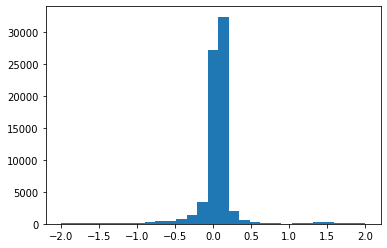

In [67]:
plt.hist(d_pT, bins=bins)

(array([ 251.,  253.,  297.,  275.,  356.,  411.,  490.,  583.,  750.,
         971., 1310., 1714., 2210., 2664., 3570., 5292., 8226., 7368.,
        5077., 3837., 3572., 5871., 3203., 1799., 1242., 1035.,  786.,
         651.,  579.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

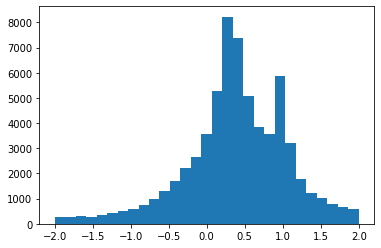

In [68]:
plt.hist(d_eta, bins=bins)

(array([ 251.,  301.,  300.,  349.,  436.,  472.,  560.,  695.,  762.,
         970., 1160., 1547., 2007., 2675., 3756., 5692., 8705., 8720.,
        5913., 4005., 3089., 2465., 1935., 1578., 1232., 1004.,  884.,
         675.,  583.]),
 array([-2.        , -1.86206897, -1.72413793, -1.5862069 , -1.44827586,
        -1.31034483, -1.17241379, -1.03448276, -0.89655172, -0.75862069,
        -0.62068966, -0.48275862, -0.34482759, -0.20689655, -0.06896552,
         0.06896552,  0.20689655,  0.34482759,  0.48275862,  0.62068966,
         0.75862069,  0.89655172,  1.03448276,  1.17241379,  1.31034483,
         1.44827586,  1.5862069 ,  1.72413793,  1.86206897,  2.        ]),
 <a list of 29 Patch objects>)

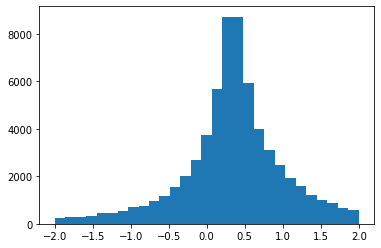

In [69]:
plt.hist(d_phi, bins=bins)